## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")

!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

cuda is enabled!
cuda is enabled!


### 1. Generate data from Archimedean spiral

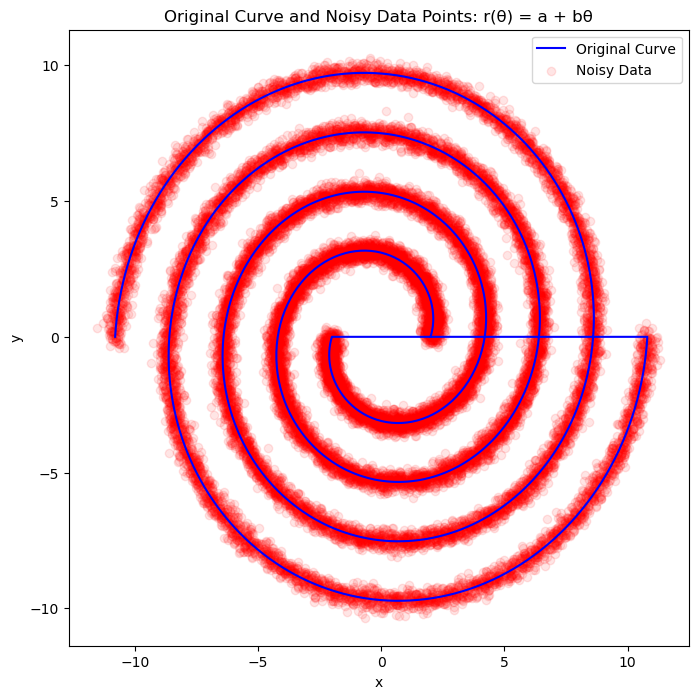

In [2]:
data = GenerateDataset(num_noisy_samples=30)

## 2. Sparse coding

In [25]:
data_tensor = torch.tensor(data, dtype=torch.float32, device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=100, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 3000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/3000], Cost = 1.249057650566101
Epoch [20/3000], Cost = 1.1063202619552612
Epoch [30/3000], Cost = 0.9844932556152344
Epoch [40/3000], Cost = 0.8833968043327332
Epoch [50/3000], Cost = 0.7997208833694458
Epoch [60/3000], Cost = 0.7306441068649292
Epoch [70/3000], Cost = 0.6736425161361694
Epoch [80/3000], Cost = 0.628296434879303
Epoch [90/3000], Cost = 0.5916868448257446
Epoch [100/3000], Cost = 0.5608012676239014
Epoch [110/3000], Cost = 0.5342341065406799
Epoch [120/3000], Cost = 0.5128682255744934
Epoch [130/3000], Cost = 0.49651846289634705
Epoch [140/3000], Cost = 0.4839650094509125
Epoch [150/3000], Cost = 0.4738752245903015
Epoch [160/3000], Cost = 0.4652056396007538
Epoch [170/3000], Cost = 0.4575667977333069
Epoch [180/3000], Cost = 0.4504427909851074
Epoch [190/3000], Cost = 0.44363805651664734
Epoch [200/3000], Cost = 0.43664950132369995
Epoch [210/3000], Cost = 0.4297049641609192
Epoch [220/3000], Cost = 0.4230901598930359
Epoch [230/3000], Cost = 0.4174329936504

### Plot learnt dictionary and clustered data points

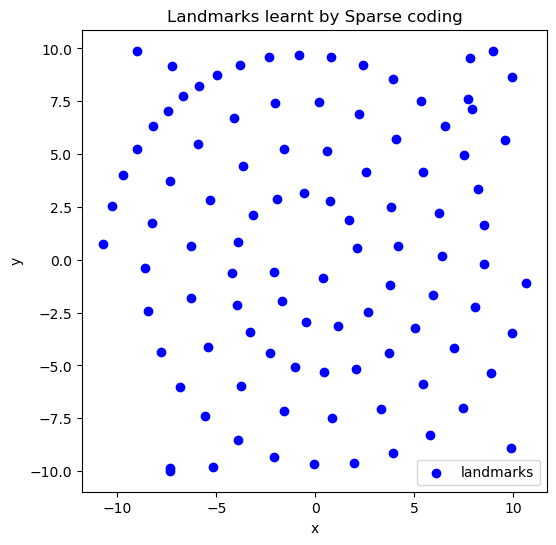

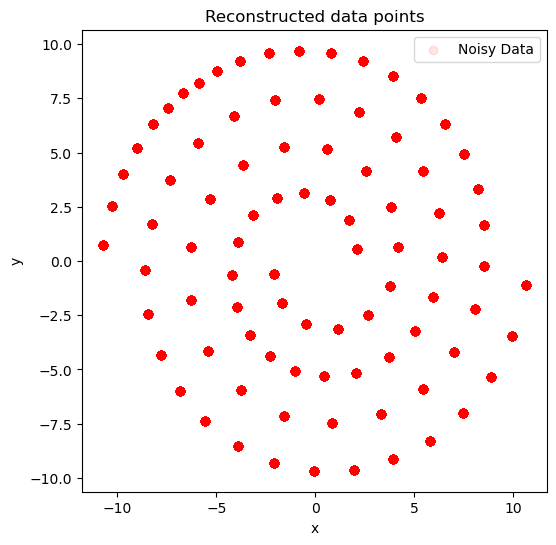

1.0


In [26]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


## 2. Assign similarity (Define D)

### 2.1 K-nearest neighbours in sparse code of data (A)

idx:  14273 / 24000
neighbor idx:  tensor([ 3875, 23873, 12673, 16672, 11074, 10272,  8671, 11073,  7873, 11873])
dist:  tensor([0.0210, 0.0503, 0.0636, 0.0771, 0.0858, 0.1093, 0.1140, 0.1200, 0.1222,
        0.1338])
tensor([[ 5.2371, -5.7497],
        [ 5.2155, -5.7868],
        [ 5.3200, -5.7583],
        [ 5.3022, -5.8196],
        [ 5.3255, -5.8084],
        [ 5.2121, -5.8573],
        [ 5.1580, -5.7000],
        [ 5.3599, -5.8184],
        [ 5.1893, -5.8596],
        [ 5.1557, -5.8455]])


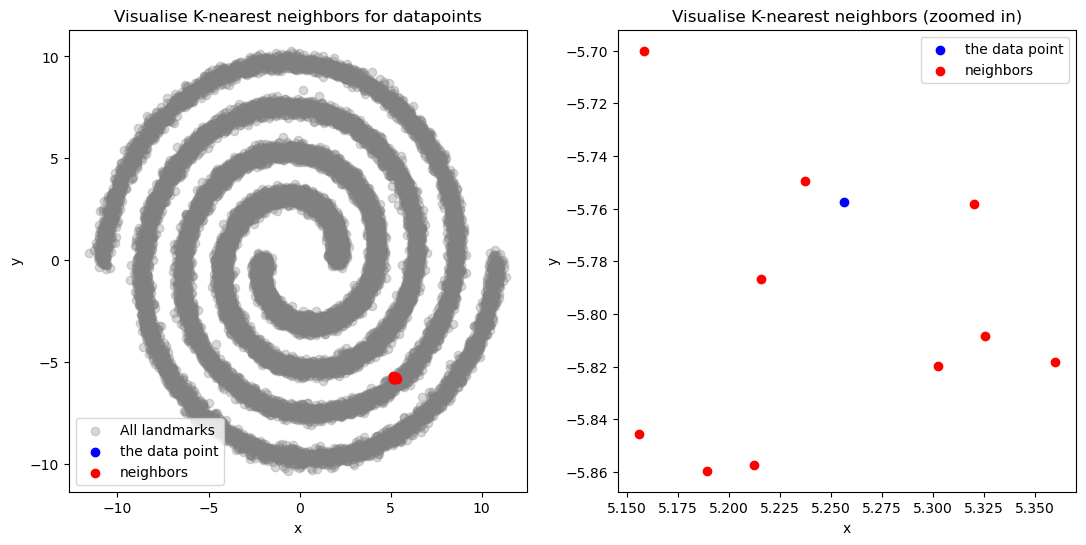

K-nearest neighbors indices of A:
tensor([[ 8801,  9601, 10403,  ...,  8000,  6400,  3201],
        [ 4804,   803, 15203,  ...,  3203, 19204, 13603],
        [23204, 12003,  8005,  ...,  2403, 19212, 10411],
        ...,
        [15196, 14396, 11196,  ..., 20796, 18397,  9596],
        [12798, 11197, 10397,  ..., 12797, 13597,  1597],
        [13599,  7999, 14399,  ..., 18399, 19199,   798]])


In [71]:
## Compute K-nearest neighbors for each element in model.Basis

# Compute K-nearest neighbors
neighbors_indices = model.KNN_Data(k=10, data=data_tensor)
print("K-nearest neighbors indices of A:")
print(neighbors_indices)

### 2.2 Construct D from B
Goal: minimising distance between neighbours


### !!Skipped due to dimension issue!!

In [72]:
# a = torch.zeros(7,4,7)
# b = torch.zeros(7,5)

# print((a@b@b.T@a.T).shape)
# # print(a.shape)
# # print(((a@a).shape))

Goal: keep topology by using interpolation (LLE on ~~dictionary~~ dataset elements)

In [73]:
## interpolation Weight matrix
neighbors = data_tensor[neighbors_indices,:] #ss (N,k,2)

print('neighbors shape: ', neighbors.shape)

local_cov = (data_tensor.unsqueeze(1)-neighbors) @ torch.transpose((data_tensor.unsqueeze(1)-neighbors), dim0=1, dim1=2) # (N,k,k)=(N,k,2)@(N,2,k)
local_cov_inv = torch.inverse(local_cov) # (N,k,k)

print(local_cov.shape, ', device =', local_cov.device)
print(local_cov[1]@local_cov_inv[1] - torch.eye(local_cov.shape[1], device=device))

weight = torch.sum(local_cov_inv,dim=1) / torch.sum(torch.sum(local_cov_inv,dim=1),dim=-1).unsqueeze(1) #(N,k)

print('weight: ', weight.unsqueeze(-1).shape)
recon_dataset = torch.transpose(neighbors,dim0=1,dim1=2) @ weight.unsqueeze(-1) # (N,2,k) @ (N,k,1)
recon_dataset.squeeze_(2)
print(recon_dataset.shape)
print('interpolation error =  ')
print(recon_dataset - data_tensor)

# check sum of weight
print(torch.sum(weight,dim=1))


neighbors shape:  torch.Size([24000, 10, 2])
torch.Size([24000, 10, 10]) , device = cuda:0
tensor([[ 0.5625,  1.5000, -0.2500, -0.2500, -0.5000,  0.4375,  0.5000,  0.7500,
          0.1250, -0.3125],
        [ 1.5000,  0.5000, -0.5000, -0.5000,  0.0000, -0.1250,  0.5000,  0.0000,
         -0.7500,  0.0000],
        [-1.3750, -1.5000,  0.5000,  1.5000, -0.2500,  0.8750,  0.0000, -0.5000,
          0.2500,  0.2500],
        [-0.5000, -2.0000,  4.0000,  1.0000, -1.0000,  1.5000,  0.0000,  0.0000,
          0.5000,  0.0000],
        [ 2.8750,  2.0000, -2.0000, -1.0000,  2.5000,  0.7500,  1.0000,  0.0000,
         -1.5000,  0.5000],
        [ 3.3750, -3.5000,  4.2500,  1.5000, -0.8750,  2.9375,  1.5000, -1.7500,
          0.0625,  0.1250],
        [ 3.0000,  2.0000,  2.0000, -2.0000,  0.5000,  0.5000,  3.0000,  4.0000,
         -1.2500,  0.5000],
        [ 0.2500,  2.0000,  0.0000,  0.0000,  0.0000, -0.5000,  2.0000, -1.0000,
          0.0000,  0.0000],
        [ 3.6250, -5.0000, -1.0000, -

torch.Size([24000, 10])
torch.Size([24000, 10])
tensor([[ 1.4748e-08, -1.7001e-08],
        [ 2.2470e-07,  5.9797e-10],
        [ 0.0000e+00,  4.4703e-08],
        ...,
        [ 1.9073e-06,  0.0000e+00],
        [ 9.5367e-07, -5.9605e-08],
        [-4.7684e-06, -2.6077e-08]], device='cuda:0')


tensor(1., device='cuda:0')

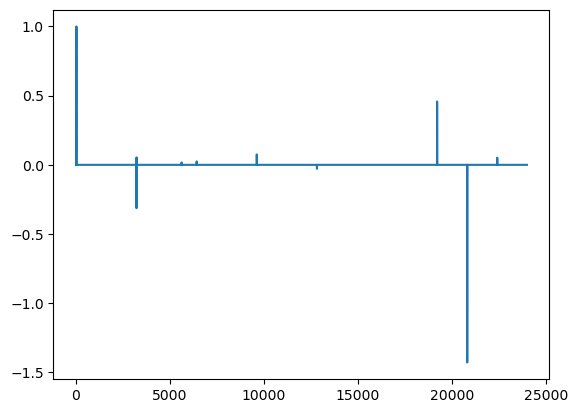

In [74]:
print(neighbors_indices.shape)
print(weight.shape)
Diff = torch.eye(Act.shape[0], device=device) # (N,N)

# Iterate over each row (for each data point)
for i in range(neighbors_indices.size(0)):
    # Select vaelements from Diff based on indices and apply weights
    if torch.isinf(weight[i]).any().item():
        print('Inf:')
        print(i)
        print(weight[i])
    Diff[i, neighbors_indices[i]] -= weight[i]


# Validation 
print(Diff @ data_tensor) # after diff, data should be ~zero
diff = Diff.cpu()[22]
plt.plot(diff)

Diff[10,10]

In [75]:
# idx = 917
# print(weight[idx])
# print(data_tensor[idx])
# print('neighbors: ')
# print(neighbors[idx])
# print(local_cov_inv.dtype)
# print(local_cov_inv[idx])

# weight_idx = torch.sum(local_cov_inv[idx],dim=0) / torch.sum(local_cov_inv[idx]) #(N,k)

# # Sum along dim=0 and then sum again
# sum1 = torch.sum(torch.sum(local_cov_inv[idx].cpu(), dim=0))

# # Sum without specifying dimension
# sum2 = torch.sum(local_cov_inv[idx].cpu())

# # Sum without specifying dimension (device version)
# sum3 = torch.sum(local_cov_inv[idx])

# # Sum4
# sum4 = torch.sum(torch.sum(local_cov_inv[idx], dim=0),dim=0)


# # Convert to Python floats and print
# print(float(sum1))
# print(float(sum2))
# print(float(sum3))
# print(float(sum4))


# print(local_cov_inv[idx,1,1])
# tensor_np = local_cov_inv[idx,1,1].cpu().numpy()

# # Print the full tensor
# np.set_printoptions(formatter={'float': '{:0.16f}'.format})
# print("Full tensor:", tensor_np)


### 2.3 Solve generalised eigenvalue problem

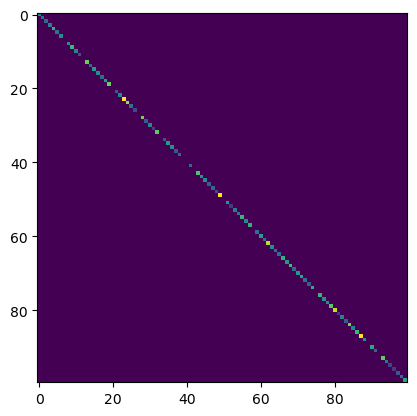

torch.Size([100, 100])
eigns calculated


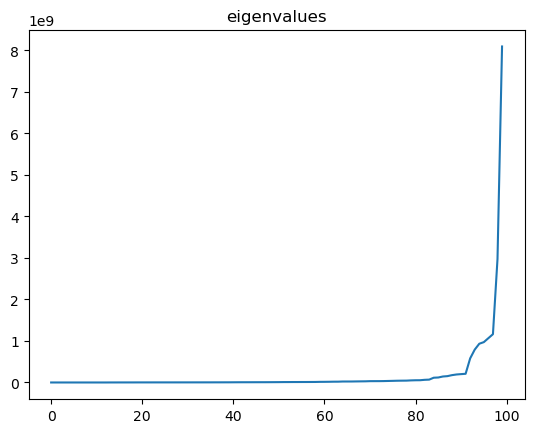

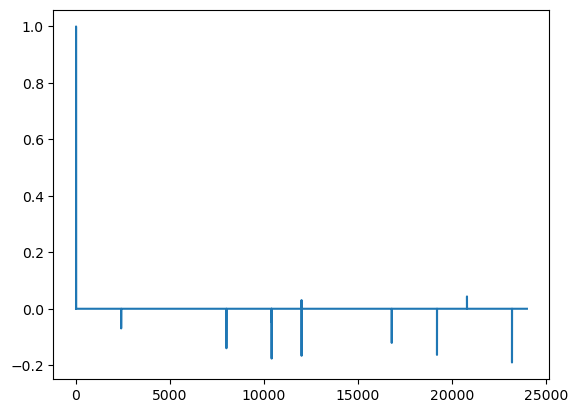

In [76]:
A = model.Activ.detach()
V = (A.T@A)/A.shape[0]

#  Compute eigenvalue decomposition of A
V_eigenvalues,V_eigenvectors = torch.linalg.eigh(V, UPLO='U')

# Square root of eigenvalues
V_sqrt_eigenvalues = torch.sqrt(V_eigenvalues)

# Reconstruct square root of A from eigenvalues and eigenvectors
sqrt_V = V_eigenvectors @ torch.diag(V_sqrt_eigenvalues) @ V_eigenvectors.T
inv_sqrt_V = torch.pinverse(sqrt_V)

plt.imshow(V.cpu())
plt.show()

Q = inv_sqrt_V @ A.T @ Diff @ Diff.T @ A @ inv_sqrt_V


if device==torch.device("mps"):
    # some operation are not supported on mps device
    Q = Q.cpu()

print(Q.shape)

Q_eigenvalues, Q_eigenvectors = torch.linalg.eigh(Q, UPLO='U')
print('eigns calculated')

plt.figure()
plt.plot(Q_eigenvalues.cpu())
plt.title('eigenvalues')
plt.show()

plt.plot(Diff.cpu()[2])

In [77]:
## Now find P
d = 30
P = Q_eigenvectors[:,0:d].T @ inv_sqrt_V

print(P.shape)
print(P)

torch.Size([30, 100])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0002, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')


### 2.4 Visualise P

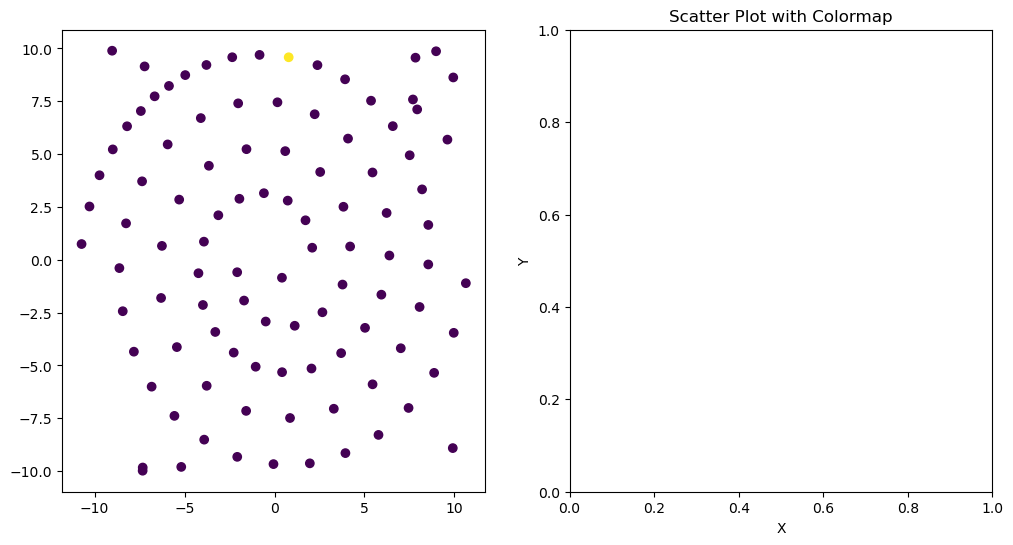

In [83]:
# Example data
idx = 20
fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

colors = P.cpu()[idx]
colors = (colors - torch.min(colors)) / (torch.max(colors) - torch.min(colors))

cmap = 'viridis'  # Example colormap

# plot dictionary elements using first row of P
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=colors, cmap=cmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.show()

### 2.5 Embedding space distance visualization

torch.Size([300, 1])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

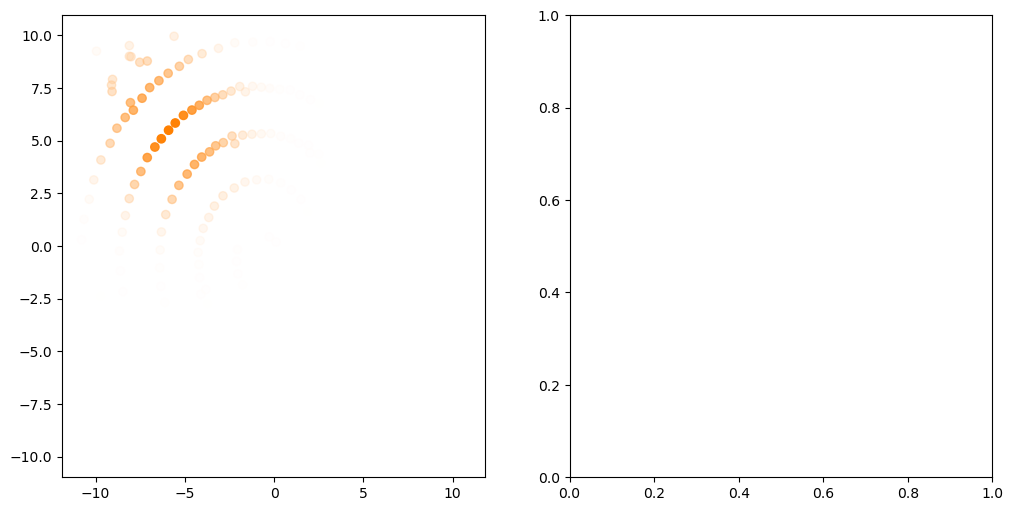

In [13]:
landmark_idx = 61
orig_sigma = 3
embed_sigma = 2e-8

def gaussian(dist, sigma):
    return torch.exp(-torch.pow(dist, 2) / (2 * sigma**2))

## Euc distance
orig_dist = torch.cdist(Bas,Bas[landmark_idx,:].unsqueeze(0),p=2)
Gaussian_orig_dist = gaussian(orig_dist,sigma=orig_sigma)
print(orig_dist.shape)

## Embedding space dist
embed_dist = torch.cdist(P.T,P.T[landmark_idx,:].unsqueeze(0),p=2)
print(embed_dist)
Gaussian_embed_dist = gaussian(embed_dist,sigma=embed_sigma)

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

map = [(1, 1, 1, 0), (1, 0.5, 0, 1)]  # Start with transparent (white) and end with orange
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', map)

# plot dictionary elements using first row of P


ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_orig_dist, cmap=cmap,vmin=1e-2, vmax=1)
ax1.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_embed_dist, cmap=cmap,vmin=1e-2, vmax=1)

ax.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')
ax1.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.show()
